# Project 2 - Autonomous Driving

By Laura Madrid & Lucas Noritomi-Hartwig

Autonomous driving is one of the major research venues these days. A lot of 
effort is devoted to it by both the academics as well as industry. In this 
project you'll familiarize yourself with some of the most important problems 
that arise in the field of autonomous driving.

The input to your algorithm is a stereo image pair and the camera parameters. 
You will also have available a set of training images where the cars have been 
annotated with 2D bounding boxes as well as viewpoint. Furthermore, you'll have 
a few images where the road has been annotated. Here are the tasks to solve:

### 1. Compute disparity between the two stereo images. We do not mind if you use existing code as long as you include a description of the algorithm you used, showing you understand what it is doing.

### 2. Compute depth of each pixel. Compute 3D location of each pixel.

In [160]:
# Import required packages
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

In [161]:
# Global Variable Definition

# Camera parameters
FOCAL_LENGTH = 7.215377000000e+02  # milimetres from files in calib folders
BASELINE = 540 # 54 centimetres from https://www.cvlibs.net/datasets/kitti/

In [162]:
def sum_of_square_diff(left_image_patch, right_image_patch) -> float:
    """
    Calculate the sum of squared differences between individual pixels.
    
    Args:
        left_image_patch (numpy.ndarray): Pixel block from left image.
        right_image_patch (numpy.ndarray): Pixel block from right image.
        
    Returns:
        float: Sum of absolute differences between the two pixel blocks.
    """
    # Check that images are of the same shape.
    if left_image_patch.shape != right_image_patch.shape:
        return -1

    return np.sum(np.square(left_image_patch - right_image_patch))

In [163]:
def compare_blocks(y, x, left_block, right_image, block_size=5, 
                   search_range=25):
    """
    Compare a block from the left image with blocks in the right image along the
    same horizonatl line to find the best match.
    
    Args:
        y (int): Row index of the left block.
        x (int): Column index of the left block.
        left_block (numpy.ndarray): Pixel block from the left image.
        right_image (numpy.ndarray): Entire right image.
        block_size (int): Size of the block. Defaults to 5.
        search_range (int): Size of the search block. Defaults to 25.
    Returns:
        tuple: (y, x) indices of the best matching block in the right image.
    """
    # Define upper bound of search range in the right image.
    x_min = max(0, x - search_range)
    x_max = min(right_image.shape[1], x + block_size)

    # Initialize the minimum sum of squared differences (SSD) and its index.
    min_ssd, index_of_min_ssd = float("inf"), None

    # Iterate over the search range in the right image.
    y_p_block_size = y + block_size
    for x in range(x_min, x_max):
        right_block = right_image[y:y_p_block_size, x:x + block_size]
        ssd = sum_of_square_diff(left_block, right_block)

        # Update the min sum of squared differences and its index accordingly.
        if ssd < min_ssd:
            min_ssd, index_of_min_ssd = ssd, (y, x)

    return index_of_min_ssd

In [164]:
def calculate_disparity_and_depth_map(left_image, right_image, block_size=5, 
                                      search_range=8):
    """
    Calculate the disparity map between two images using block matching.

    Args:
        left_image (numpy.ndarray): Left image.
        right_image (numpy.ndarray): Right image.
        block_size (int): Size of the block. Defaults to 5.
        search_range (int): Size of the search block. Defaults to 25.
    Returns:
        disparity_map (numpy.ndarray): Disparity map.
        depth_map (numpy.ndarray): Depth map.
    """
    h, w = left_image.shape
    disparity_map, depth_map = np.zeros((h, w)), np.zeros((h, w))

    # Iterate over the entire image except for the borders
    h_m_block_size, w_m_block_size = h - block_size, w - block_size
    for y in tqdm(range(block_size, h_m_block_size)):
        y_p_block_size = y + block_size
        for x in range(block_size, w_m_block_size):
            left_block = left_image[y:y_p_block_size, x:x + block_size]
            min_index = compare_blocks(y, x, left_block, right_image,
                                       block_size, search_range)
            # Compute pixel disparity
            disparity_map[y, x] = abs(min_index[1] - x)

    return disparity_map

In [165]:
import cv2
import numpy as np

def calculate_disparity_and_depth_map_cv2(left_image, right_image, block_size=5, 
                                          search_range=8):
    """
    Calculate the disparity map between two images using block matching.

    Args:
        left_image (numpy.ndarray): Left image.
        right_image (numpy.ndarray): Right image.
        block_size (int): Size of the block. Defaults to 5.
        search_range (int): Size of the search block. Defaults to 25.
    Returns:
        disparity_map (numpy.ndarray): Disparity map.
        depth_map (numpy.ndarray): Depth map.
    """

    # Initialize the StereoSGBM object
    stereo = cv2.StereoSGBM_create(minDisparity=0,
                                   numDisparities=16 * search_range,
                                   blockSize=block_size,
                                   uniquenessRatio=10,
                                   speckleWindowSize=100,
                                   speckleRange=32,
                                   disp12MaxDiff=1,
                                   P1=8 * 3 * block_size ** 2,
                                   P2=32 * 3 * block_size ** 2)

    # Compute disparity
    disparity_map = stereo.compute(left_image, right_image)

    return disparity_map

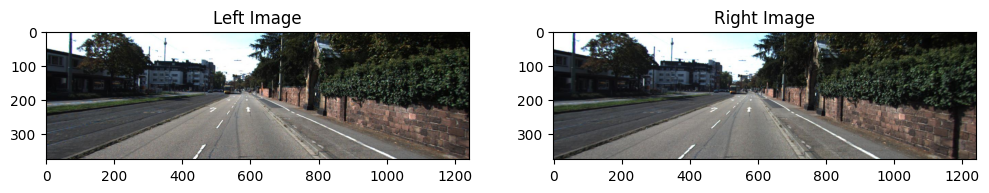

In [166]:
# Load sample images
left_image = cv2.imread('./project2/train/image_left/um_000001.jpg')
right_image = cv2.imread('./project2/train/image_right/um_000001.jpg')


plt.figure(figsize=(12, 6))

# Plot the original door image in the first subplot
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(left_image, cv2.COLOR_BGR2RGB))
plt.title("Left Image")

# Plot the image overlayed with boundaries
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(right_image, cv2.COLOR_BGR2RGB))
plt.title("Right Image")

# Display the plot
plt.show()

left_image_gray = cv2.cvtColor(left_image, cv2.COLOR_BGR2GRAY)
right_image_gray = cv2.cvtColor(right_image, cv2.COLOR_BGR2GRAY)

In [167]:
# Set block size and search range
block_size = 5
search_range = 8

# Compute disparity and depth map
disparity_map = calculate_disparity_and_depth_map(left_image_gray, 
                                                  right_image_gray, 
                                                  block_size, 
                                                  search_range)

# Compute depth map
depth_map = (FOCAL_LENGTH * BASELINE) / (np.abs(disparity_map))

100%|██████████| 365/365 [00:44<00:00,  8.17it/s]
/var/folders/wg/mnn7ls5j0nz1vchp1r094d740000gn/T/ipykernel_56689/246621613.py:12: RuntimeWarning: divide by zero encountered in divide
  depth_map = (FOCAL_LENGTH * BASELINE) / (np.abs(disparity_map))


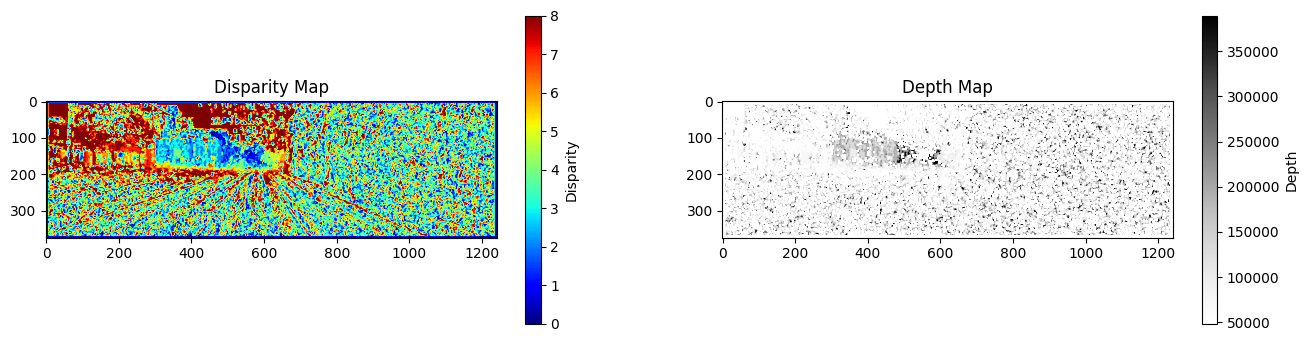

In [168]:
# Visualize the disparity map and depth map

# Set figure size
plt.figure(figsize=(16, 4))

# Visualize the computed disparity map
plt.subplot(1, 2, 1)
plt.imshow(disparity_map, cmap="jet")
plt.colorbar(label='Disparity')
plt.title("Disparity Map")

# Visualize the computed depth map
plt.subplot(1, 2, 2)
plt.imshow(depth_map, cmap="Greys")
plt.colorbar(label='Depth')
plt.title("Depth Map")

# Display the plot
plt.show()

/var/folders/wg/mnn7ls5j0nz1vchp1r094d740000gn/T/ipykernel_56689/3812752835.py:12: RuntimeWarning: divide by zero encountered in divide
  depth_map_cv2 = (FOCAL_LENGTH * BASELINE) / (np.abs(disparity_map_cv2))


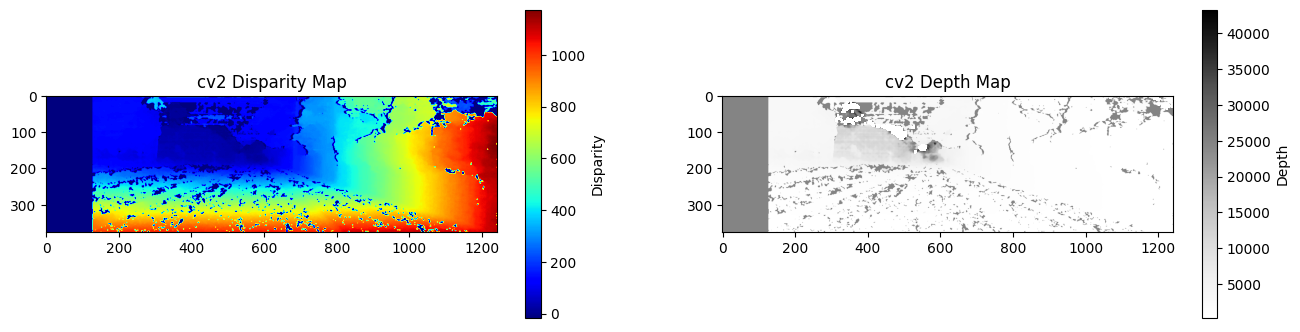

In [169]:
# Set block size and search range
block_size = 5
search_range = 8

# Compute disparity map by cv2
disparity_map_cv2 = calculate_disparity_and_depth_map_cv2(left_image_gray, 
                                                          right_image_gray, 
                                                          block_size, 
                                                          search_range)

# Compute depth map
depth_map_cv2 = (FOCAL_LENGTH * BASELINE) / (np.abs(disparity_map_cv2))

# Set figure size
plt.figure(figsize=(16, 4))

# Visualize the computed disparity map
plt.subplot(1, 2, 1)
plt.imshow(disparity_map_cv2, cmap="jet")
plt.colorbar(label='Disparity')
plt.title("cv2 Disparity Map")

# Visualize the computed depth map
plt.subplot(1, 2, 2)
plt.imshow(depth_map_cv2, cmap="Greys")
plt.colorbar(label='Depth')
plt.title("cv2 Depth Map")

# Display the plot
plt.show()

In [171]:
print(disparity_map.shape, depth_map.shape)

(375, 1242) (375, 1242)


### 3. Train a road classifier on a set of annotated images, and compute road pixels in your image. Which features would you use? Try to use both 2D and 3D features.

In [172]:
import os
from skimage import io

In [173]:
# Function to load images from a directory
def load_images_from_directory(directory):
    images = []
    for filename in sorted(os.listdir(directory)):
        img_path = os.path.join(directory, filename)
        # Avoiding ".DS_store" file that may or may not appear in directory
        if os.path.isfile(img_path) and not filename.startswith('.'):
            try:
                img = io.imread(img_path)
                images.append(img)
            except Exception as e:
                print(f"Error loading {img_path}: {e}")
    return images

In [174]:
# Path to the directories containing the images
left_image_dir = "project2/train/image_left"
right_image_dir = "project2/train/image_right"
ground_truth_dir = "project2/train/gt_image_left"
num_images = 135

# Load left images
left_images = load_images_from_directory(left_image_dir)
assert(len(left_images) == num_images)

# Load right images
right_images = load_images_from_directory(right_image_dir)
assert(len(right_images) == num_images)

# Load ground truth images
ground_truth_images = load_images_from_directory(ground_truth_dir)
assert(len(ground_truth_images) == num_images)

In [176]:
# Set block size and search range
block_size = 5
search_range = 25

disparity_maps, depth_maps = [], []
for i in range(num_images):
    disparity_maps.append(calculate_disparity_and_depth_map_cv2(
        cv2.cvtColor(left_images[i], cv2.COLOR_BGR2GRAY), 
        cv2.cvtColor(right_images[i], cv2.COLOR_BGR2GRAY), block_size, 
        search_range))

depth_maps = [(FOCAL_LENGTH * BASELINE) / (np.abs(disparity_map)) 
              for disparity_map in disparity_maps]

/var/folders/wg/mnn7ls5j0nz1vchp1r094d740000gn/T/ipykernel_56689/895607899.py:12: RuntimeWarning: divide by zero encountered in divide
  depth_maps = [(FOCAL_LENGTH * BASELINE) / (np.abs(disparity_map))
